In [77]:
import time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"


import sys
sys.path.append("/home/jdli/transpec")
from tqdm import tqdm
import joblib 
from kvxp.specformer import SpecFormer, SpecFormer2
from kvxp.data import  GXP_AP_4lb
from kvxp.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../docs/models/scaler_labels_0208.gz', 
                        bias=2, scale_ext=10):
    scaler_labels = joblib.load(scaler_name)
    
    y   = scaler_labels.inverse_transform(y_hat/scale_ext-bias)
    e_y = (e_y_hat * scaler_labels.scale_)/scale_ext
    return y, e_y



def infer_4lbs_model(model, data_loader, n_outputs=1, transcale_method=recover_scale_label,
                     device=torch.device('cuda:0')):
    
    out_lst, out_lst2 = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            x1 = data['x'][:,:n_enc].view(-1, 1,n_enc)
            x2 = data['x'][:, n_enc:n_cut].reshape(-1, n_hi, n_dim)
            
            output = model(x1=x1, x2=x2)
            
            x2[:, 0:] = 0
            output2 = model(x1=x1, x2=x2)
                
            out_lst   = np.append(out_lst,  output.cpu().numpy())
            out_lst2  = np.append(out_lst2,  output2.cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,n_outputs)
    out_lst = np.hstack([out_lst for _ in range(4)])
    
    out_lst2 = np.array(out_lst2).reshape(-1,n_outputs)
    out_lst2 = np.hstack([out_lst2 for _ in range(4)])
    y, _ = transcale_method(out_lst, out_lst)
    y2, _ = transcale_method(out_lst2, out_lst2)
    return {'labels':y, 'labels2':y2, 'source_id':id_lst}



In [62]:
data_dir = "/data/jdli/gaia/"

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")
tr_file = "ap_xp_13286.npy"


device = torch.device('cuda:0')

BATCH_SIZE = int(2**6)
gdata  = GXP_AP_4lb(
    data_dir+tr_file, part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=BATCH_SIZE)

x = gdata[0]['x'].cpu()

In [103]:
tr_epoch = 500

preflix_name = "sp2_alpha_{:d}_ep{:d}.pt"

model_dir  = "/data/jdli/gaia/model/0221/"
model_name = preflix_name.format(*[0, tr_epoch])

print(model_dir+model_name)

###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

n_enc = 110
n_hi = 116
n_outputs = 1
n_dim = 64
n_cut = n_hi*n_dim + n_enc
n_head = 4
n_layer = 4
pred_names   = ['aom', 'aom_xp']


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    if fold==0:
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        tr_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=tr_subsampler)
        
        model = SpecFormer(
            n_enc, n_outputs, device=device, n_hi=n_hi, channels=n_dim, 
        ).to(device)
        
        tr_dict = torch.load(model_dir+model_name)
        tr_dict = remove_prefix(torch.load(model_dir+model_name))
        model.load_state_dict(tr_dict)

        labels_infer = infer_4lbs_model(
            model, tr_loader, device=device, 
            transcale_method=recover_scale_label
        )

        rdf = pd.DataFrame(np.c_[labels_infer['labels'][:,-1], labels_infer['labels2'][:,-1]], 
                           columns=pred_names)
        rdf = rdf.assign(source_id=labels_infer['source_id'])


/data/jdli/gaia/model/0221/sp2_alpha_0_ep500.pt
FOLD 0
--------------------------------


100%|█████████████████████████████████████████████████████████████████████████| 167/167 [00:36<00:00,  4.64it/s]


In [104]:
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))


0.038997751209405324
0.060407225337659305


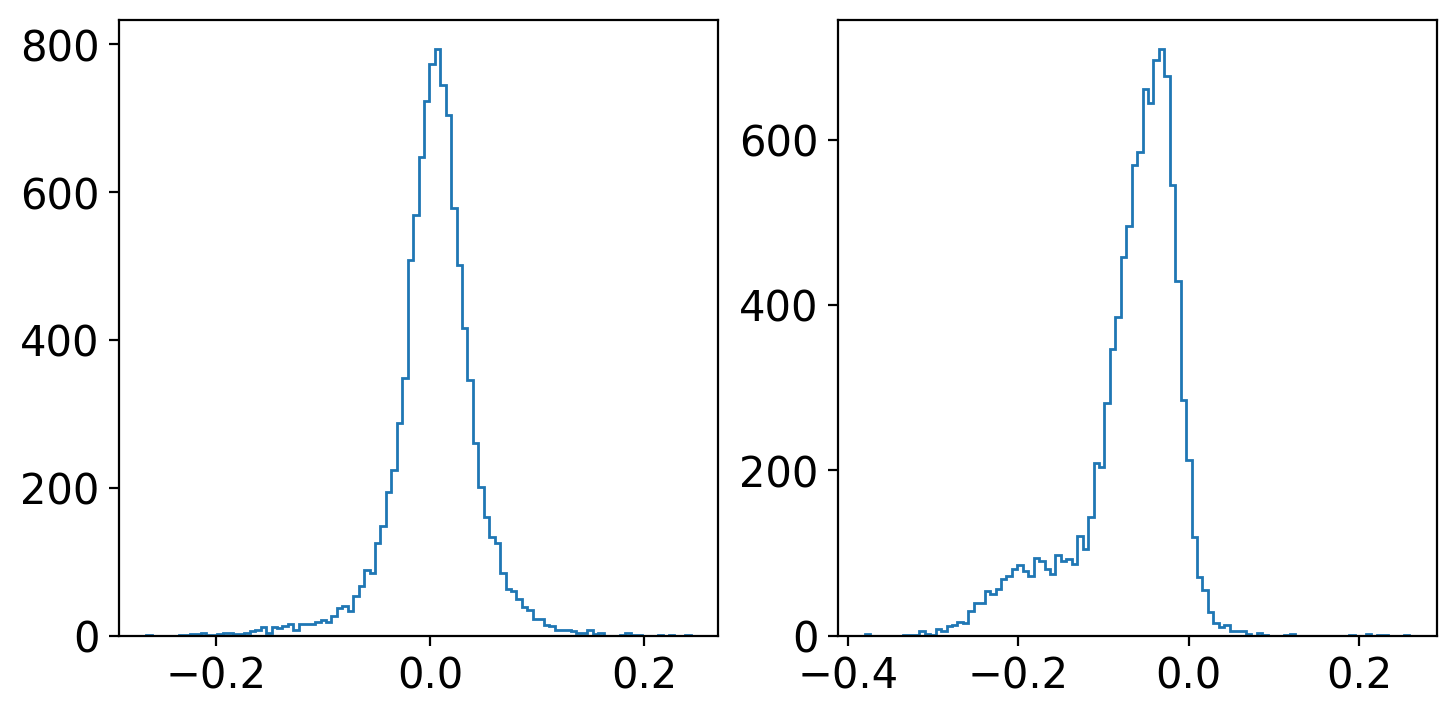

In [105]:
fig, axs = plt.subplots(1,2, figsize=(8.5,4))
ax1, ax2 = axs.ravel()
ax1.hist(rdf_val['aom']-rdf_val['ALPHA_M'], bins=100, histtype='step');
print(np.std(rdf_val['ALPHA_M']-rdf_val['aom']))

ax2.hist(rdf_val['aom_xp']-rdf_val['ALPHA_M'], bins=100, histtype='step');
print(np.std(rdf_val['ALPHA_M']-rdf_val['aom_xp']))


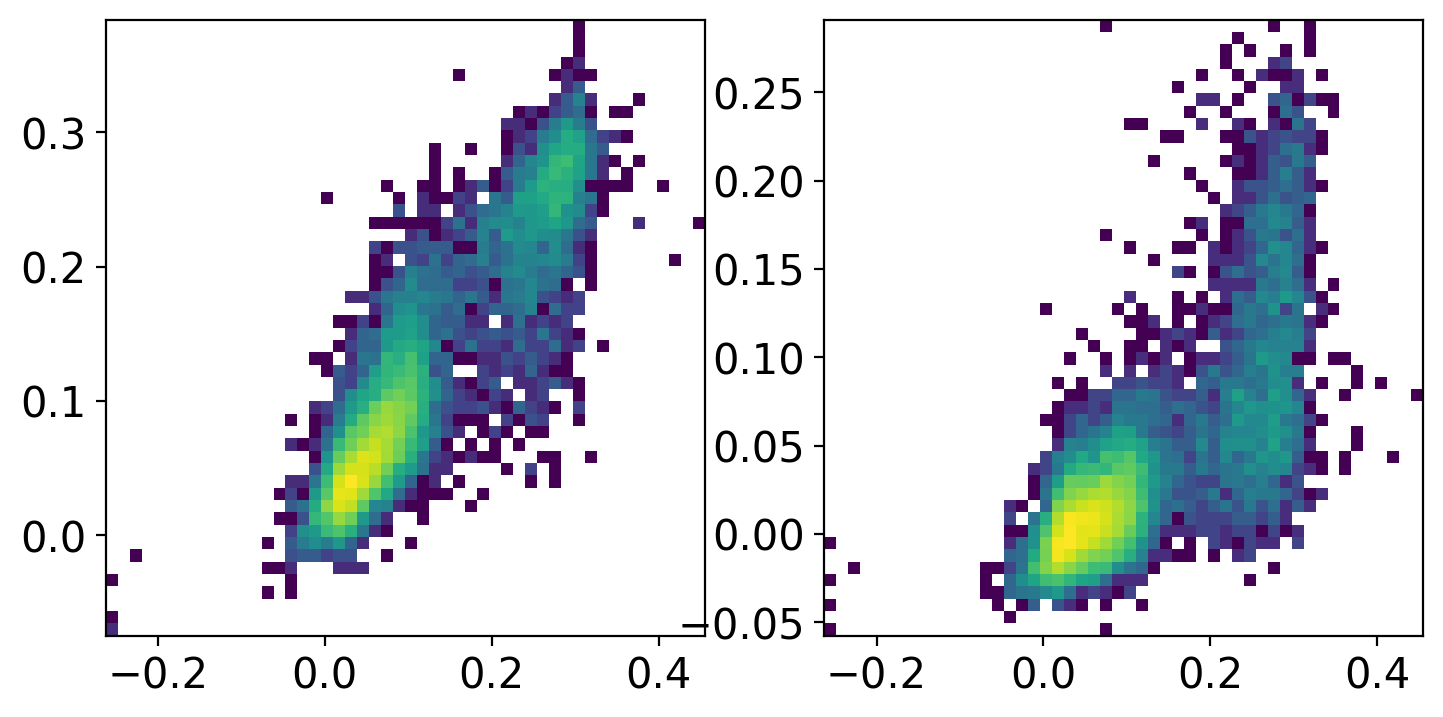

In [106]:
fig, axs = plt.subplots(1,2, figsize=(8.5,4))
ax1, ax2 = axs.ravel()
ax1.hist2d(rdf_val['ALPHA_M'], rdf_val['aom'], bins=50, norm=colors.LogNorm());
ax2.hist2d(rdf_val['ALPHA_M'], rdf_val['aom_xp'], bins=50, norm=colors.LogNorm());


In [102]:
ind = rdf_val['M_H']<-0.7

print("[M/H]<-0.7:", np.std(rdf_val['ALPHA_M'][ind]-rdf_val['aom'][ind]))
print("[M/H]<-0.7:", np.std(rdf_val['ALPHA_M'][ind]-rdf_val['aom_xp'][ind]))
print("[M/H]>-0.7:", np.std(rdf_val['ALPHA_M'][~ind]-rdf_val['aom'][~ind]))
print("[M/H]>-0.7:", np.std(rdf_val['ALPHA_M'][~ind]-rdf_val['aom_xp'][~ind]))

[M/H]<-0.7: 0.05687816682576223
[M/H]<-0.7: 0.0878731644928134
[M/H]>-0.7: 0.04001269266747603
[M/H]>-0.7: 0.05519572611461753
